## 500birds API

Autonomous recording units are an increasingly popular method of surveying sound-producing animals, such as birds, bats, frogs, and wolves. These recorders are capable of capturing the sounds occurring in a soundscape for months at a time, making them excellent choices for low-cost, large-scale studies. To fully realize their potential, recordings generated by recorders must be scanned by automated techniques.

The analysis of bird songs in recordings is especially challenging due to their enormous diversity. Over the course of a field season, dozens or even hundreds of bird species can be present in a field site, meaning that automated techniques must be able to identify a wide variety of songs. Vocalizations can be highly variable within species, and even within a single individual.

To enable field biologists to study birds at larger scales, we at the [Kitzes Lab](http://www.kitzeslab.org/) have developed a classifier capable of detecting over 500 common species of the United States and Canada. This notebook demonstrates the use of our classifier. Given a short audio file, it splits the file into five-second segments, and outputs the model's top predictions for species present in the files. The classifier is split into two models, one for passerines and one for non-passerines.

### Imports and constants

Constants required are:
* `API_URL`: the URL on your local machine of the Docker container
* `WAV_FILE`: the path to a single-channel wav file to analyze, between 5 and 20 seconds long
* `NUM_PREDICTIONS`: number of predictions to output (20 is typical and graphs well!)

In [1]:
import io
import json
import requests
import pandas as pd

%autosave 0

API_URL = "http://localhost:8081/v1/birds"
WAV_FILE = "./client/soundscape.wav"  # also try: './client/cardinalis-cardinalis.wav'
NUM_PREDICTIONS = 20

Autosave disabled


### Functions

In [2]:
SPECIES_DF = pd.read_csv("./species_table.csv")


def translate_names(name, from_col="scientific", to_col="bn_common"):
    """
    Translate between two columns of translation df
    
    Args:
        name (str): name to translate
        from_col (str): title of column in translation df 
            to find `name` in (should be `'scientific'`)
        to_col (str): title of column in translation df 
            to translate `name` to
    
    Returns: contents in `to_col` for the first row 
        in which `name` is found in `from_col`
    """

    return SPECIES_DF[SPECIES_DF[from_col] == name][to_col].iloc[0]


def get_audio(inp):
    """
    Read audio file from the filesystem 
    
    Args: 
        inp (str): The input audio in WAV format
        
    Returns: bytes of audio file
    """

    with open(inp, "rb") as audio:
        return audio.read()


def predict(data, endpoint="passerines"):
    """
    Predict contents of audio file
    
    Args:
        data (bytes): audio bytes read from file using get_audio
        endpoint (str): which endpoint to use, "passerines" or "non_passerines"
    
    Returns:
        if request was successful: returns dictionary
            with key 'predictions' equal to a list of lists.
            There are `num_images` inner lists, each a string 
            of predictions for each 5s segment of 
            the audio, in the format:
                ['passer-montanus: 0.00000',
                 'passer-domesticus: 0.00000',
                 ...,
                 'lagopus-leucura: 0.00000']
            
        if request was not successful: returns None
            This can happen if the audio was not in the correct
            format (between 5-20 seconds, single-channel)
    
    Raises:
        exception: if the API raises an unexpected exception
    """

    try:
        r = requests.post(f"{API_URL}/detect/{endpoint}", data=data)

        if r.ok:
            return r.json()
        else:
            return None

    except Exception as e:
        print("Exception running API: {}".format(e))


def get_spect(data):
    """
    Get 5s spectrogram(s) of audio file
    
    Args:
        data (bytes): audio bytes read from file
    
    Returns:
        if request was successful: returns dictionary
            with key 'images' equal to a list of grayscale, three-channel
            299 x 299 images, each representing up to 5s of audio,
            
            This output is a list of lists with the following contents:
                len(images): `num_images` lists
                len(images[0]): 299 lists
                len(images[0][0]): 299 lists
                len(images[0][0][0]): 3 floats from 0-255
                    image is grayscale, so the elements
                    within each innermost array are
                    the same, e.g. [141.0, 141.0, 141.0]
                    
            Each image can be converted to a PIL image using:
                pil_img = Image.fromarray(((np.array(image))).astype(np.uint8))
        
            
        if request was not successful: returns None.
            This can happen if the audio was not in the correct
            format (between 5-20 seconds, single-channel)
        
        
    """

    try:
        r = requests.post(f"{API_URL}/spectrogram", data=data)

        if r.ok:
            return r.json()
        else:
            return None

    except Exception as e:
        print("Exception running API: {}".format(e))

### Get the bytes of the audio file to send to the API

In [3]:
audio_bytes = get_audio(WAV_FILE)

### Retrieve and run prediction on audio

In [4]:
# Get predictions
result_dict = predict(audio_bytes, endpoint="passerines")  # Also try non_passerines

if "error" in result_dict.keys():
    print(result_dict["error"])
else:
    predictions = result_dict["predictions"]

### Get images of spectrograms to display

In [5]:
# Get spectrograms
image_dict = get_spect(audio_bytes)

if "error" in image_dict.keys():
    print(image_dict["error"])
else:
    images = image_dict["images"]
    num_images = len(images)

### Display images and predictions

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

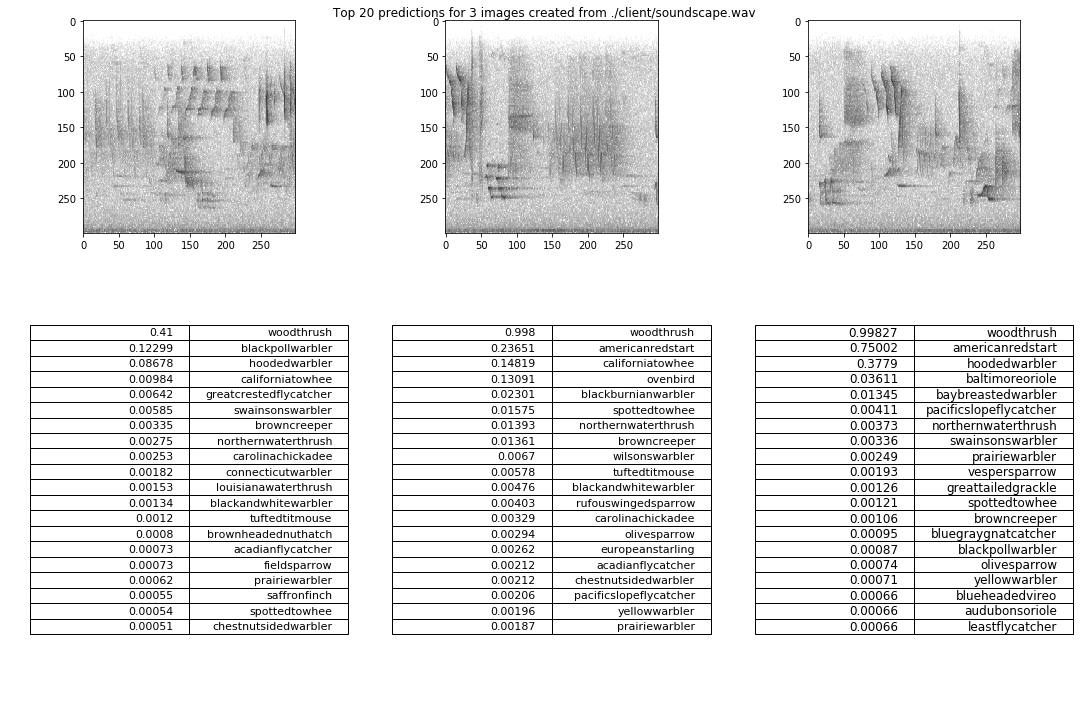

In [7]:
# Set up a figure to plot
fig = plt.figure(
    constrained_layout=True, figsize=((num_images * 10) / 2, (NUM_PREDICTIONS) / 2)
)
grid = fig.add_gridspec(
    nrows=2,
    ncols=num_images,
    figure=fig,
    # wspace = 0.0,
    # hspace = -1,
    height_ratios=[1, NUM_PREDICTIONS / 10],
)

# Separate the image from the results subplots
img_axs = []
result_axs = []
for col in range(num_images):
    img_axs.append(fig.add_subplot(grid[0, col]))
    result_axs.append(fig.add_subplot(grid[1, col]))


plt.suptitle(
    f"Top {NUM_PREDICTIONS} predictions for {num_images} images created from {WAV_FILE}"
)

# Plot each image and result
for img_idx, preds in enumerate(predictions):
    
    # Plot image
    image = images[img_idx]
    pil_img = Image.fromarray(((np.array(image))).astype(np.uint8))
    img_axs[img_idx].imshow(pil_img)

    # Plot predictions as a table
    preds_df = pd.DataFrame.from_dict(preds, orient="index", columns=["prediction"])
    preds_df["scientific-name"] = preds_df.index.values

    # Sort values and subset to top 20
    preds_df = preds_df.sort_values(by="prediction", ascending=False).iloc[
        :NUM_PREDICTIONS
    ]

    # Translate from scientific to common names
    preds_df["common-name"] = preds_df["scientific-name"].apply(translate_names)

    table = result_axs[img_idx].table(
        cellText=preds_df.drop("scientific-name", axis=1).values.tolist(), loc="center"
    )
    # the_table.auto_set_font_size(False)
    table.set_fontsize(20)
    result_axs[img_idx].axis("off")

plt.show()